В данной работе мы познакомимся с простейшими методами обработки и анализа данных: Principal Component Analysis (PCA), Linear Discriminant Analysis (LDA). Эти методы будут применены для построения видео-признаков, описывающие форму губ пользователя во время произнесения цифр. Кроме этого, для сравнения, будут получены тривиальные признаки, описывающие форму губ - расстояние между верхней и нижней губой + расстояние между левым и правым уголком рта.

В качестве входных данных имеются подготовленные (вырезанные и отмасшабированные к размеру 100x60) изображения рта для каждого кадра видео + timestamp кадра (в мс.) + 20 координат характеристических точек губ.

In [1]:
import os
import numpy as np
import skimage
from skimage import io
from skimage import color
from skimage import transform
import matplotlib.pyplot as plt 
import io
import pickle
import fnmatch
import random

%matplotlib inline

In [27]:
work_dir = "../data/lip_reading/"
input_dir = "1_video_lips/"
features_dir = "2_features/"

models_path = work_dir + "models/"

# создаем выходную директорию
if os.system("mkdir -p " + models_path) != 0:
    print("ERROR: can't create models directory")

<B>Задание 1.</B> Начнем с простой задачи: построение признаков на основе разметки характеристических точек губ.

Характеристические точи расположены в соответствии с рисунком:

![title](img/mouth_landmarks.png)

Одними из наиболее простых и интуитивно понятных признаков являются пара расстояний: 
- между верхней и нижней губой (зеленые точки) 
- между уголками рта (розовые точки)

Имея на входе коортдинаты указанных точек для всех изображений видео необходимо рассчитать требуемые расстояния (lm_dist). Дополнительно необходимо привести рассчитанные значения к нулевому среднему и единичной дисперсии 

In [33]:
def prepare_features_landmarks(lm):
    assert (lm.shape[1] == 20 and lm.shape[2] == 2), "Incorrect landmarks shape"
    
    T = lm.shape[0]
    lm_dist = np.zeros([T, 2])
    
    # ------------- TODO -------------------------------------------------
    # --------------------------------------------------------------------
    
    return lm_dist

Проверим, что признаки строятся

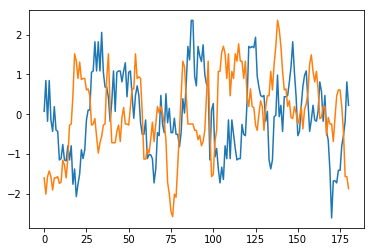

In [34]:
with open(work_dir + "test/F0015_03_9385741620_Android_SM_Gal_J3.pickle", "rb") as f:
    img_data = pickle.load(f)
    lm = pickle.load(f)
    ts = pickle.load(f)
    frames = pickle.load(f)
    
    lm_features = prepare_features_landmarks(lm)
    plt.plot(lm_features[:,0])
    plt.plot(lm_features[:,1])
    plt.show()

<B> Задание 2. </B> Прежде чем приступить к анализу данных необходимо сделать предварительную обрабработку входных изображений. Эта предобработка может включать в себя следующие шаги: 
- нормализация интенсивности изображения
- рассчет различных признаков, таких как HOG, HAAR
- (Обязательно) приведение каждого изображения к одномерному вектору размерности 1500 (=50x30) при помощи функции numpy.array.reshape

In [35]:
def prepare_data_img(session_img):
    result_shape = [50,30]
    assert (len(session_img.shape) == 3), "Incorrect images shape"
    assert (session_img.shape[1] == result_shape[0]), "Incorrect images shape"
    assert (session_img.shape[2] == result_shape[1]), "Incorrect images shape"
    
    T = session_img.shape[0]
    img_resized = np.zeros([T, result_shape[0]*result_shape[1]])
    
    # ------------- TODO -------------------------------------------------
    # --------------------------------------------------------------------
    
    return img_resized
    

<B>Задание 3.</B> Релизовать применение модели PCA к данным (сжатие) и их восстановление по формулам:

$y_t = (x_t - \mu) \cdot V$

$x_t^{restore} = (\lambda y_t) \cdot V + \mu$

где $x_t$ - входной вектор, $y_t$ - проекция PCA, $\mu$ - среднее значение модели PCA (pca_mean),  $V$ - ортогональная матрица проекций PCA (pca_eig), $\lambda$ - собственные вектора (pca_vals)


In [36]:
def apply_pca(data, pca_model):
    assert (len(data.shape) == 2), "Incorrect data shape"
    
    (pca_mean, pca_eig, pca_vals) = pca_model
    
    # ------------- TODO -------------------------------------------------
    #features_pca = 
    # --------------------------------------------------------------------
    
    return features_pca

In [37]:
def restore_pca(features_pca, pca_model):
    assert (len(features_pca.shape) == 2), "Incorrect features_pca shape"
    
    (pca_mean, pca_eig, pca_vals) = pca_model
    
    # ------------- TODO -------------------------------------------------
    #data_restored = 
    # --------------------------------------------------------------------
    
    return data_restored

Проверьте корректность реализации путем сжатия и восстановления тестовых данных 

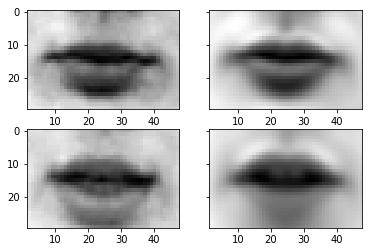

In [38]:
with open(work_dir + "test/pca.pickle", "rb") as f:
    pca_model_test = pickle.load(f)
    
with open(work_dir + "test/img_data.pickle", "rb") as f:
    img_data = pickle.load(f)
    
    feature_pca = apply_pca(img_data, pca_model_test)
    img_data_restored = restore_pca(feature_pca, pca_model_test)
    
    fig, axes = plt.subplots(2,2, sharey=True)
    axes[0,0].imshow(img_data[0,:].reshape([50,30]).T, cmap="gray")
    axes[0,1].imshow(img_data_restored[0,:].reshape([50,30]).T, cmap="gray")
    axes[1,0].imshow(img_data[25,:].reshape([50,30]).T, cmap="gray")
    axes[1,1].imshow(img_data_restored[25,:].reshape([50,30]).T, cmap="gray")
    plt.show() 

Также нам понадобится вспомогательная функция, осуществляющая приведение построенных признаков к фиксированному frame-rate с тем, чтобы обеспечить в дальнейшем синхронность видео- и аудио-признаков

In [39]:
def resample_features(features, ts, frame_step = 10.):
    assert (len(features.shape) == 2), "Incorrect features shape size"
    T = ts.shape[0]
    frames_num = int(np.max(ts)/frame_step + 1.) + 1
    frames_bounds = ((ts[0:T-1, 0] + ts[1:T, 0])/(2.*frame_step) + 1.).astype(np.int32)
    frames_bounds = np.hstack(([0], frames_bounds, [frames_num]))

    features_resampled = np.zeros([frames_num, features.shape[1]])
    for t in range(T):
        features_resampled[frames_bounds[t]:frames_bounds[t+1],:] = features[t,:]
    return features_resampled

<B>Задание 4.</B> Построение модели $PCA$, $PCA_W$ (необязательно) и $LDA$ (необязательно). 

Для построения PCA достаточно будет оценить среднее значение $M$ и ковариационную матрицу для всех данных $S$:

$M = \frac{\sum_{h=1}^{H}\sum_{t=1}^{T_h} x_{h,t}}{\sum_h {T_h}} $

$S = \frac{\sum_{h=1}^{H}\sum_{t=1}^{T_h} (x_{h,t}-M)(x_{h,t}-M)^T}{\sum_h {T_h}}$

где $H$ - количество видео, $T_h$ - количество фреймов в видео $h$

Однако, нас больше интересует вариативность, которая возникает внутри одного видео при изменении формы губ. Мы можем оценить более точно её, построив матрицу $S_W$ (ковариационная матрица вариативности внутри каждого произнесения):

$S_W = \frac{\sum_{h=1}^{H}\sum_{t=1}^{T_h} (x_{h,t}-M_h)(x_{h,t}-M_h)^T}{\sum_h {T_h}}$

где

$M_h = \frac{\sum_{t=1}^{T_h} x_{h,t}}{T_h} $

Фактически, разница между $S$ и $S_W$ в том, что при подсчете $S_W$ мы вычитаем среднее значение всех кадров текущего видео, а не глобальное среднее значение.

Для построения $LDA$ нам понадобится еще одна матрица (ковариационная матрица вариативности между различными видео):

$S_B = \frac{\sum_{h=1}^{H} (M_h - M)(M_h - M)^T}{H}$

Классический подход при построении LDA - это минимизация внутри-классовой дисперсии ($S_W$) с одновременным увеличением меж-классовой дисперсии ($S_B$). В нашем случае в качестве класса можно рассматривать отдельное видео, в этом случае внутриклассовая вариативность будет обусловлена в большей степени движением губ, поэтому при оценке модели LDA мы должны решить обратную задачу: максимизировать внутри-классовую дисперсию  с одновременной минимизацией меж-классовой дисперсии.


Техничесвая сложность состоит в том, что зачастую загрузить все данные в память одновременно не представляется возможным, поэтому требуемые матрицы нужно "аккумулировать", последовательно загружая данные.

In [40]:
data_dir = work_dir + input_dir + "train/"
files_all = fnmatch.filter(os.listdir(data_dir), "*.pickle")

# для ускорения расчетов будет брать не более 4 файлов от каждого пользователя, где он произносит 10 цифр
files_per_person = 4

person_files = {}
for f in files_all:
    person_id = f.split('_')[0]
    phrase_id = f.split('_')[2]
    if (len(phrase_id) == 10):
        person_files.setdefault(person_id, []).append(f)  

print("Persons num: {}".format(len(person_files)))

files_train = []
for person_id, files in person_files.items():
    random.shuffle(files)
    files_train = files_train + files[0:min(files_per_person, len(files))]

print("Train files num: {}".format(len(files_train)))
counter = 0

# -------- TODO: размер может отличаться ----------------
data_dim = 1500
# -------------------------------------------------------

data_all_list = []
data_between = np.empty((0,data_dim))

mean_global = np.zeros([data_dim])
S = np.zeros([data_dim, data_dim])
S_B = np.cov([data_dim, data_dim])
S_W = np.cov([data_dim, data_dim])


for file in files_train:
    if (counter%100 == 0):
        print("progress: {} / {}".format(counter,len(files_train)))
    with open(data_dir + file, "rb") as f:
        img = pickle.load(f)
        lm = pickle.load(f)
        ts = pickle.load(f)
        frames = pickle.load(f)
        filename = os.path.splitext(file)[0]

        img_data = prepare_data_img(img)
        
        # -------------------- TODO ----------------------------------
        # аккумулирование статистик
        #-------------------------------------------------------------
        counter += 1

# -------------------- TODO ----------------------------------  
# S = 
# S_W = 
# S_B = 
#-------------------------------------------------------------

# сохраним подсчитанные матрицы в бинарный файл
with open(models_path + "pca_lda_data.pickle", "wb") as f:
    pickle.dump(mean_global, f)
    pickle.dump(S, f)
    pickle.dump(S_B, f)
    pickle.dump(S_W, f)
print("FINISHED")

Persons num: 656
Train files num: 2394
progress: 0 / 2394
progress: 100 / 2394
progress: 200 / 2394
progress: 300 / 2394
progress: 400 / 2394
progress: 500 / 2394
progress: 600 / 2394
progress: 700 / 2394
progress: 800 / 2394
progress: 900 / 2394
progress: 1000 / 2394
progress: 1100 / 2394
progress: 1200 / 2394
progress: 1300 / 2394
progress: 1400 / 2394
progress: 1500 / 2394
progress: 1600 / 2394
progress: 1700 / 2394
progress: 1800 / 2394
progress: 1900 / 2394
progress: 2000 / 2394
progress: 2100 / 2394
progress: 2200 / 2394
progress: 2300 / 2394
FINISHED


При необходимости можно всегда загрузить подсчитанные модели

In [15]:
with open(models_path + "pca_lda_data.pickle", "rb") as f:
    mean_global = pickle.load(f)
    S = pickle.load(f)
    S_B = pickle.load(f)
    S_W = pickle.load(f)

In [43]:
def estimate_model(size, analysis_matrix, model_mean):
    
    eigvals, eigvecs = np.linalg.eig(analysis_matrix)
    eiglist = [(eigvals[i], eigvecs[:, i]) for i in range(len(eigvals))]

    # sort the eigvals in decreasing order
    eiglist = sorted(eiglist, key = lambda x : x[0], reverse = True)

    # take the first eigvectors
    V = np.array([eiglist[i][1] for i in range(size)]).T
    D = np.array([eiglist[i][0] for i in range(size)])

    plt.plot(D)
    plt.show()
    return (model_mean, V/np.sqrt(D), D)

Построение модели PCA

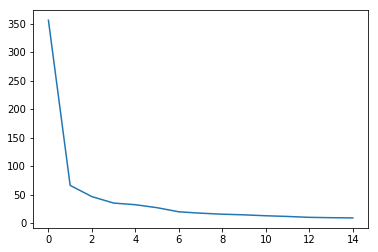

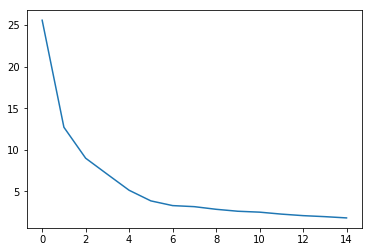

In [44]:
pca_model = estimate_model(15, S, mean_global)
with open(models_path + "pca.pickle", "wb") as f:
    pickle.dump(pca_model, f)

pca_model_W = estimate_model(15, S_W, np.zeros([1500]))
with open(models_path + "pca_W.pickle", "wb") as f:
    pickle.dump(pca_model_W, f)

Построение модели LDA

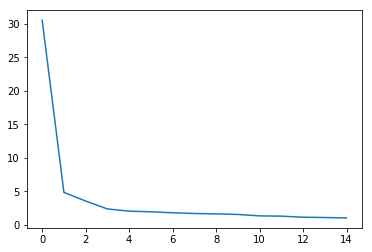

In [45]:
S_B_regular = 0.5*S_B + 0.5*np.eye(S_B.shape[0])
mat_LDA = np.dot(np.linalg.pinv(S_B_regular), S_W)

lda_model = estimate_model(15, mat_LDA, mean_global)
with open(models_path + "lda.pickle", "wb") as f:
    pickle.dump(lda_model, f)

In [9]:
with open(models_path + "pca.pickle", "rb") as f:
    pca_model = pickle.load(f)

with open(models_path + "pca_W.pickle", "rb") as f:
    pca_model_W = pickle.load(f)
    
with open(models_path + "lda.pickle", "rb") as f:
    lda_model = pickle.load(f)

Посмотрим, как выгядит одна из компонент базиса построенных PCA и LDA

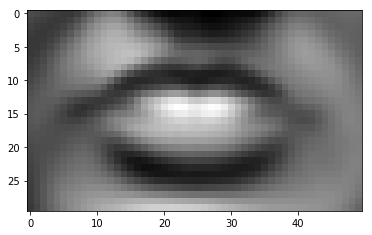

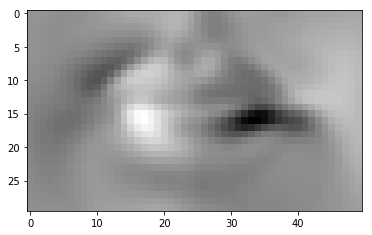

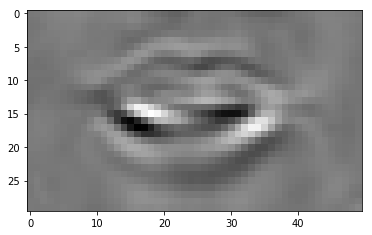

In [47]:
index = 11
plt.imshow(pca_model[1][:,index].reshape([50,30]).T,cmap="gray")
plt.show()
plt.imshow(pca_model_W[1][:,index].reshape([50,30]).T,cmap="gray")
plt.show()
plt.imshow(lda_model[1][:,index].reshape([50,30]).T,cmap="gray")
plt.show()

<b> Задание 5. </b> Попробовать сжать и восстановить картинку какого-нибудь видео из папки test

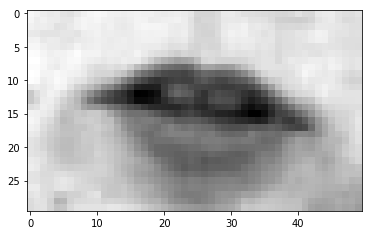

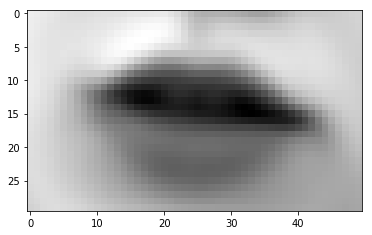

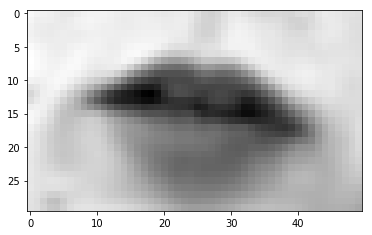

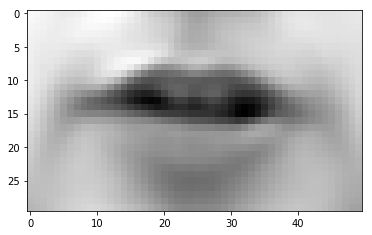

In [50]:

with open(work_dir + input_dir + "test/F0199_01_98560_Android_SM_Gal_J3.pickle", "rb") as f:
    img = pickle.load(f)
    lm = pickle.load(f)
    ts = pickle.load(f)
    frames = pickle.load(f)
    
    img_data = prepare_data_img(img)
    
    #---------------- TODO ----------------------------------------
    #img_data_resored = 
    
    #img_data_resored_W = 
    
    #img_data_resored_lda = 
    #--------------------------------------------------------------
    
    plt.imshow(img_data[15,:].reshape([50,30]).T, cmap="gray")
    plt.show()
    plt.imshow(img_data_resored[15,:].reshape([50,30]).T, cmap="gray")
    plt.show()
    plt.imshow(img_data_resored_W[15,:].reshape([50,30]).T, cmap="gray")
    plt.show()
    plt.imshow(img_data_resored_lda[15,:].reshape([50,30]).T, cmap="gray")
    plt.show()

Подготовка признаков для TRAIN и TEST множества

In [24]:
for case in ["train/", "test/"]:
    print("PROCESS: " + case)
    data_dir = work_dir + input_dir + case
    files = fnmatch.filter(os.listdir(data_dir), "*.pickle")
    counter = 0
    
    os.system("mkdir -p " + work_dir + features_dir + "landmarks/" + case)
    os.system("mkdir -p " + work_dir + features_dir + "pca/" + case)
    os.system("mkdir -p " + work_dir + features_dir + "pca_W/" + case)
    os.system("mkdir -p " + work_dir + features_dir + "lda/" + case)
    for file in files:
        counter += 1
        if counter%10 == 0:
            print("processed: " + str(counter) + " / " + str(len(files)))
        
        with open(data_dir + file, "rb") as f:
            img = pickle.load(f)
            lm = pickle.load(f)
            ts = pickle.load(f)
            frames = pickle.load(f)
            filename = os.path.splitext(file)[0]

            
            img_data = prepare_data_img(img)

            # Calculate features landmarks
            feature_lm = prepare_features_landmarks(lm)
            np.save(work_dir + features_dir + "landmarks/" + case + filename + ".npy", 
                    resample_features(feature_lm, ts).astype(np.float32))
            
            # Calculate features PCA
            feature_pca = apply_pca(img_data, pca_model)
            np.save(work_dir + features_dir + "pca/" + case + filename + ".npy", 
                    resample_features(feature_pca, ts).astype(np.float32))

            # Calculate features PCA_WITHIN
            feature_pca_W = apply_pca(img_data - img_data.mean(axis=0), pca_model_W)
            np.save(work_dir + features_dir + "pca_W/" + case + filename + ".npy", 
                    resample_features(feature_pca_W, ts).astype(np.float32))

            # Calculate features LDA
            feature_lda = apply_pca(img_data, lda_model)
            np.save(work_dir + features_dir + "lda/" + case + filename + ".npy", 
                    resample_features(feature_lda, ts).astype(np.float32))
                
                
        
        

PROCESS: train/
processed: 10 / 9435
processed: 20 / 9435
processed: 30 / 9435
processed: 40 / 9435
processed: 50 / 9435
processed: 60 / 9435
processed: 70 / 9435
processed: 80 / 9435
processed: 90 / 9435
processed: 100 / 9435
processed: 110 / 9435
processed: 120 / 9435
processed: 130 / 9435
processed: 140 / 9435
processed: 150 / 9435
processed: 160 / 9435
processed: 170 / 9435
processed: 180 / 9435
processed: 190 / 9435
processed: 200 / 9435
processed: 210 / 9435
processed: 220 / 9435
processed: 230 / 9435
processed: 240 / 9435
processed: 250 / 9435
processed: 260 / 9435
processed: 270 / 9435
processed: 280 / 9435
processed: 290 / 9435
processed: 300 / 9435
processed: 310 / 9435
processed: 320 / 9435
processed: 330 / 9435
processed: 340 / 9435
processed: 350 / 9435
processed: 360 / 9435
processed: 370 / 9435
processed: 380 / 9435
processed: 390 / 9435
processed: 400 / 9435
processed: 410 / 9435
processed: 420 / 9435
processed: 430 / 9435
processed: 440 / 9435
processed: 450 / 9435
pro

processed: 3620 / 9435
processed: 3630 / 9435
processed: 3640 / 9435
processed: 3650 / 9435
processed: 3660 / 9435
processed: 3670 / 9435
processed: 3680 / 9435
processed: 3690 / 9435
processed: 3700 / 9435
processed: 3710 / 9435
processed: 3720 / 9435
processed: 3730 / 9435
processed: 3740 / 9435
processed: 3750 / 9435
processed: 3760 / 9435
processed: 3770 / 9435
processed: 3780 / 9435
processed: 3790 / 9435
processed: 3800 / 9435
processed: 3810 / 9435
processed: 3820 / 9435
processed: 3830 / 9435
processed: 3840 / 9435
processed: 3850 / 9435
processed: 3860 / 9435
processed: 3870 / 9435
processed: 3880 / 9435
processed: 3890 / 9435
processed: 3900 / 9435
processed: 3910 / 9435
processed: 3920 / 9435
processed: 3930 / 9435
processed: 3940 / 9435
processed: 3950 / 9435
processed: 3960 / 9435
processed: 3970 / 9435
processed: 3980 / 9435
processed: 3990 / 9435
processed: 4000 / 9435
processed: 4010 / 9435
processed: 4020 / 9435
processed: 4030 / 9435
processed: 4040 / 9435
processed: 

processed: 7190 / 9435
processed: 7200 / 9435
processed: 7210 / 9435
processed: 7220 / 9435
processed: 7230 / 9435
processed: 7240 / 9435
processed: 7250 / 9435
processed: 7260 / 9435
processed: 7270 / 9435
processed: 7280 / 9435
processed: 7290 / 9435
processed: 7300 / 9435
processed: 7310 / 9435
processed: 7320 / 9435
processed: 7330 / 9435
processed: 7340 / 9435
processed: 7350 / 9435
processed: 7360 / 9435
processed: 7370 / 9435
processed: 7380 / 9435
processed: 7390 / 9435
processed: 7400 / 9435
processed: 7410 / 9435
processed: 7420 / 9435
processed: 7430 / 9435
processed: 7440 / 9435
processed: 7450 / 9435
processed: 7460 / 9435
processed: 7470 / 9435
processed: 7480 / 9435
processed: 7490 / 9435
processed: 7500 / 9435
processed: 7510 / 9435
processed: 7520 / 9435
processed: 7530 / 9435
processed: 7540 / 9435
processed: 7550 / 9435
processed: 7560 / 9435
processed: 7570 / 9435
processed: 7580 / 9435
processed: 7590 / 9435
processed: 7600 / 9435
processed: 7610 / 9435
processed: 

processed: 1370 / 2909
processed: 1380 / 2909
processed: 1390 / 2909
processed: 1400 / 2909
processed: 1410 / 2909
processed: 1420 / 2909
processed: 1430 / 2909
processed: 1440 / 2909
processed: 1450 / 2909
processed: 1460 / 2909
processed: 1470 / 2909
processed: 1480 / 2909
processed: 1490 / 2909
processed: 1500 / 2909
processed: 1510 / 2909
processed: 1520 / 2909
processed: 1530 / 2909
processed: 1540 / 2909
processed: 1550 / 2909
processed: 1560 / 2909
processed: 1570 / 2909
processed: 1580 / 2909
processed: 1590 / 2909
processed: 1600 / 2909
processed: 1610 / 2909
processed: 1620 / 2909
processed: 1630 / 2909
processed: 1640 / 2909
processed: 1650 / 2909
processed: 1660 / 2909
processed: 1670 / 2909
processed: 1680 / 2909
processed: 1690 / 2909
processed: 1700 / 2909
processed: 1710 / 2909
processed: 1720 / 2909
processed: 1730 / 2909
processed: 1740 / 2909
processed: 1750 / 2909
processed: 1760 / 2909
processed: 1770 / 2909
processed: 1780 / 2909
processed: 1790 / 2909
processed: 

<b>Задание 5.</b> Сохранить полученные фичи - в дальнейшем они вам пригодятся

<b>Задание 6\*.</b> Попробовать какие-нибудь более сложные методы сжатия данных (CNN-автоэнкодеры и т.п.)